## Problem statement 
###  Develop an evolutionary algorithm based system which will find the largest amount of money that can be packed into a security van.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt

### Import data

In [2]:
l = []
with open("BankProblem.txt") as f:
    next(f)
    for line in f:
        (key, val) = line.split()
        l.append(val.replace(':',''))
        
df = pd.DataFrame(np.array(l).reshape(int(len(l)/3),3),columns=['Bag','Weight','Value'])
df

,Bag,Weight,Value
0,1,9.4,57
1,2,7.4,94
2,3,7.7,59
3,4,7.4,83
4,5,2.9,82
...,...,...,...
95,96,3.9,76
96,97,9.6,53
97,98,7.1,59
98,99,3.9,40


### Create Functions

#### A) Generate initial population of chromosome given a size   

In [3]:
def generate_population(chromosome,population):
    par = []
    for i in range(0,population):
        genome_bags = np.arange(0,2)
        pop = np.random.choice(genome_bags,chromosome)
        par.append(pop)
    par = [l.tolist() for l in par]
    return par

#### B) Selecting parents from the population

In [4]:
def select_parents(l,base_pop):
    re = []
    for i in range(0,len(l)):
        re.append(float(base_pop['Value'][l[i]]))
    top_2 = sorted(range(len(re)), key=lambda i: re[i])[-2:]
    top_2_pos = list(l[i] for i in top_2)
    return top_2_pos

#### C) Crossover between two parents taken

In [5]:
# function for implementing the single-point crossover 
def crossover(rand1,rand2,Crossover_point): 

    rand1 = list(rand1) 
    rand2 = list(rand2)
    
    # interchanging the genes 
    for i in range(Crossover_point,len(rand1)): 
        rand1[i], rand2[i] = rand2[i], rand1[i] 
    cr1 = ''.join(str(v) for v in rand1)
    cr2 = ''.join(str(v) for v in rand2)
    return cr1, cr2 

#### D) Mutate the children from the crossover considering the number of mutation given

In [6]:
def mutate(cr,chromosome,No_of_mutation):
    for no in range(0,No_of_mutation):
        cr = list(cr)
        i,j=np.random.choice(chromosome,2,replace=False)
        cr[i],cr[j] = cr[j],cr[i]
    mut = []
    for i in range(0,len(cr)):
        mut.append(int(float(cr[i])))
    return mut

#### E) Find the chromosome weight and value 

In [7]:
def chromosome_weight_value(ip_list):
    
    result = []
    weight = 0
    value = 0
    ip_array = ip_list
    for j in range(0,chromosome):
        weight += float(df['Weight'][j])*int(ip_array[j])
        value += float(df['Value'][j])*int(ip_array[j])

    result.append((ip_array,weight,value))
    return result

#### F) Fitness function to check the if chromosome weight is less than van capacity and repalce weaker one

In [8]:
def fitness(base_pop,population,security_van_capacity):
    
    
    base_pop = base_pop[base_pop['Weight']<= security_van_capacity]
    base_pop = base_pop.nlargest(population,'Value')

    base_pop = base_pop.reset_index(drop=True)
    
    return base_pop

#### G) Main function that collate everything 

In [9]:
def generate_results(chromosome,population,tournament_size,security_van_capacity,no_of_mutation,Crossover_point,iterations):

    # Generate random samples
    p = generate_population(chromosome,population)
    col = ['Chromosome','Weight','Value']
    base_pop = pd.DataFrame(columns=col)
    
    # Initial chromosome_weight_value
    for i in range(0,len(p)):
        tp = pd.DataFrame(chromosome_weight_value(p[i]),columns=col)
        base_pop = pd.concat([base_pop,tp])
    
    base_pop = base_pop.reset_index(drop=True)
    base_pop['Iteration'] = 0
    
    iter_pop=[]
    
    for iteration in range(0,iterations):

        if len(base_pop)>3:
            l = np.random.choice(len(base_pop),tournament_size).tolist()
            old_pop = base_pop.copy()
        else: 
            base_pop = old_pop.copy()
            l = np.random.choice(len(old_pop),tournament_size).tolist()
        
        # Select parents
        p = select_parents(l,base_pop)
        p1 = p[0]
        p2 = p[1]
        
        # Crossover
        cr1,cr2 = crossover(base_pop['Chromosome'][p1],base_pop['Chromosome'][p2],Crossover_point)
        
        # Mutation 
        mutated_1 = mutate(cr1,chromosome,no_of_mutation)
        mutated_2 = mutate(cr2,chromosome,no_of_mutation)

        # New chromosome_weight_value
        idx = np.arange(population,population+2)
        tp = []
        x = 0
        for i in (mutated_1,mutated_2):
            tp.append(chromosome_weight_value(i))
            temp_pop = pd.DataFrame(tp[x],columns=col, index=idx)
            x += x
        
        temp_pop['Iteration'] = iteration
        
        base_pop = pd.concat([base_pop,temp_pop])
        
        # Final fitness and repalcement
        base_pop = fitness(base_pop,population,security_van_capacity)
    return base_pop

#### H) Iterate through multiple parameter and compare results

In [10]:
def evolve_problem(chromosome,population,tournament_size,security_van_capacity,no_of_mutation,Crossover_point,iterations):
    for i in iterations:
        for t in tournament_size:
            for m in no_of_mutation:
                for p in population:
                    out = generate_results(chromosome,p,t,security_van_capacity,m,Crossover_point,i)
                    if len(out)>0:
                        tp.append((p,chromosome,t,m,Crossover_point,out.nlargest(1,'Value')['Iteration'][0],out.nlargest(1,'Value')['Weight'][0],out.nlargest(1,'Value')['Value'][0],out.nlargest(1,'Value')['Chromosome'][0]))
    return tp

### Testing the experiment to obtain the results

In [11]:
%%time

col = ['Population Size','Chromosome Size','Tournament Size','Mutation Rate','Crossover Point','Iteration','Weight','Total Value','Chromosome']

tp = []

security_van_capacity = 277    # Max capacity of the van  
chromosome = 100               # Number of bags
iterations = [10000]           # Number of iterations
population = [20,50,100]       # Multiple Population size
no_of_mutation = [1,2,3]       # No of mutations 
tournament_size = [4,8,12]     # Tournament size 
Crossover_point = int(np.random.choice(chromosome,1))   # Random Crossover point 

# Function call to run the code with the above specified parameter 
tp = evolve_problem(chromosome,population,tournament_size,security_van_capacity,no_of_mutation,Crossover_point,iterations)

collated = pd.DataFrame(tp, columns=col)
collated = collated.sort_values(by='Total Value', ascending=False)
collated = collated.reset_index(drop=True)

# Top 1 result for each combinations 
print('Top results for each combinations\n')
collated

Top results for each combinations

Wall time: 33min 59s


,Population Size,Chromosome Size,Tournament Size,Mutation Rate,Crossover Point,Iteration,Weight,Total Value,Chromosome
0,100,100,12,1,75,9334,276.9,4379.0,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
1,100,100,12,2,75,9849,276.9,4377.0,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
2,50,100,8,3,75,6921,276.7,4374.0,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
3,50,100,8,2,75,6688,276.8,4372.0,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, ..."
4,100,100,12,3,75,9390,276.8,4372.0,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, ..."
5,50,100,4,1,75,8349,276.7,4364.0,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
6,50,100,12,3,75,5215,276.7,4364.0,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
7,100,100,4,2,75,9522,276.1,4363.0,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
8,50,100,4,2,75,9096,276.5,4362.0,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
9,20,100,4,2,75,9869,277.0,4358.0,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."


### Visualize the results

In [12]:
# View top 10 performing results via heatmap

cm = sns.light_palette("#2ecc71", as_cmap=True)
styled_table = collated.head(10).iloc[:,0:8].style.background_gradient(cmap=cm)
print('Top 10 performing results')
styled_table

Top 10 performing results


,Population Size,Chromosome Size,Tournament Size,Mutation Rate,Crossover Point,Iteration,Weight,Total Value
0,100,100,12,1,75,9334,276.900000,4379.000000
1,100,100,12,2,75,9849,276.900000,4377.000000
2,50,100,8,3,75,6921,276.700000,4374.000000
3,50,100,8,2,75,6688,276.800000,4372.000000
4,100,100,12,3,75,9390,276.800000,4372.000000
5,50,100,4,1,75,8349,276.700000,4364.000000
6,50,100,12,3,75,5215,276.700000,4364.000000
7,100,100,4,2,75,9522,276.100000,4363.000000
8,50,100,4,2,75,9096,276.500000,4362.000000
9,20,100,4,2,75,9869,277.000000,4358.000000


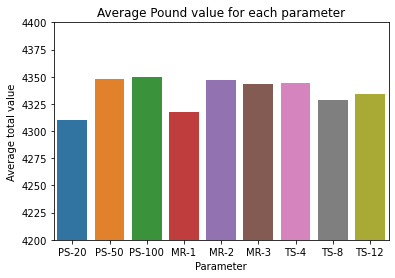

In [13]:
import warnings
warnings.filterwarnings("ignore")


ps = collated.groupby(['Population Size'])['Total Value'].mean()
mr = collated.groupby(['Mutation Rate'])['Total Value'].mean()
ts = collated.groupby(['Tournament Size'])['Total Value'].mean()

ts = pd.DataFrame(ts).reset_index()
ts['TS'] = 'TS-'
ts['Parameter'] = ts['TS']+ts['Tournament Size'].map(str)
ts = ts.rename(columns={"Total Value": "Average total value"})

mr = pd.DataFrame(mr).reset_index()
mr['MR'] = 'MR-'
mr['Parameter'] = mr['MR']+mr['Mutation Rate'].map(str)
mr = mr.rename(columns={"Total Value": "Average total value"})

ps = pd.DataFrame(ps).reset_index()
ps['PS'] = 'PS-'
ps['Parameter'] = ps['PS']+ps['Population Size'].map(str)
ps = ps.rename(columns={"Total Value": "Average total value"})

avg_re = pd.concat([ps[['Average total value','Parameter']],mr[['Average total value','Parameter']],ts[['Average total value','Parameter']]])

plot = sns.barplot(avg_re['Parameter'],avg_re['Average total value'])
plot.set(ylim=(4200, 4400))
plt.title('Average Pound value for each parameter')
plt.show()

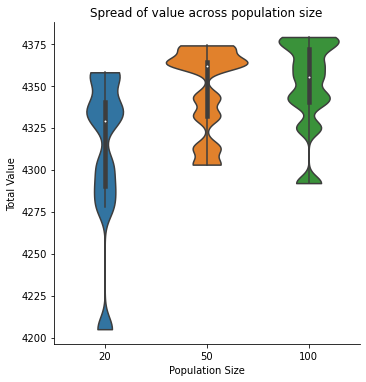

In [14]:
sns.catplot(x="Population Size", y="Total Value", kind="violin", bw=.15, cut=0, data=collated)
plt.title('Spread of value across population size')
plt.show()

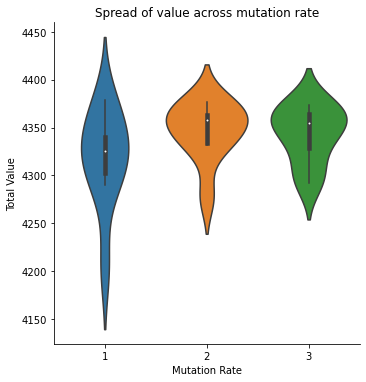

In [15]:
sns.catplot(x="Mutation Rate", y="Total Value", kind="violin",data=collated)
plt.title('Spread of value across mutation rate')
plt.show()

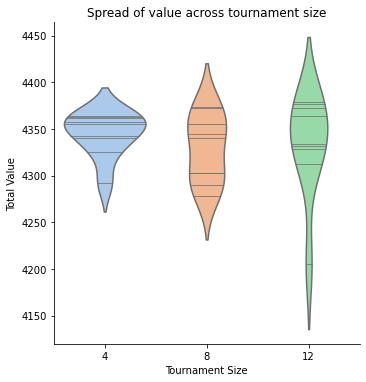

In [16]:
sns.catplot(x="Tournament Size", y="Total Value", kind="violin", inner="stick", split=True,palette="pastel",data=collated)
plt.title('Spread of value across tournament size')
plt.show()